In [56]:
# %%
from IPython import get_ipython
from IPython.display import display
# %%
!pip install albumentations
!pip install nibabel
!pip install opencv-python
!pip install segmentation_models_pytorch
!pip install torch torchvision torchaudio
!pip install tensorflow

import nibabel as nib
from torch.utils.data import Dataset
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings

print(f"Imports done")
from google.colab import drive
drive.mount('/content/drive')
# 1. Set up paths and parameters
DATA_DIR = "/content/drive/My Drive/data/ISLES-2022"  # or your actual data folder path
N_MODELS = 1
EPOCHS = 1 # Reduce epochs for testing, increase for proper training
BATCH_SIZE = 1 # Reduce batch size for testing, increase if GPU memory allows
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("All devices:", tf.config.list_logical_devices('TPU'))
# ...existing code...

TARGET_SHAPE = (64, 64, 64)  # Choose a shape your GPU can handle

def pad_or_crop_5d(x, target_shape):
    # x: [B, C, D, H, W] or [B, 1, D, H, W]
    _, _, D, H, W = x.shape
    tD, tH, tW = target_shape
    # Pad
    pad_d = max(tD - D, 0)
    pad_h = max(tH - H, 0)
    pad_w = max(tW - W, 0)
    x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])
    # Crop
    x = x[:, :, :tD, :tH, :tW]
    return x


# ...existing code...

def safe_pad_or_crop(x, target_shape):
    # Accepts [B, C, D, H, W] or [B, D, H, W] or [C, D, H, W]
    if x.ndim == 4:
        x = x.unsqueeze(0)  # Add batch dim if missing
    if x.ndim == 5:
        _, _, D, H, W = x.shape
        tD, tH, tW = target_shape
        pad_d = max(tD - D, 0)
        pad_h = max(tH - H, 0)
        pad_w = max(tW - W, 0)
        x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])
        x = x[:, :, :tD, :tH, :tW]
    else:
        raise ValueError(f"Input shape not supported: {x.shape}")
    return x

# %%
class ISLESDataset3D(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        print(f"entering 3D samples")
        mask_root = os.path.join(root_dir, "derivatives")
        for subject in os.listdir(root_dir):
            if subject.startswith("sub-"):
                ses_dir = os.path.join(root_dir, subject, "ses-0001")
                if os.path.exists(ses_dir):
                    dwi_dir = os.path.join(ses_dir, "dwi")
                    anat_dir = os.path.join(ses_dir, "anat")

                    # Look for both dwi and adc files in the dwi directory
                    dwi_files = [f for f in os.listdir(dwi_dir) if f.endswith("_dwi.nii.gz")]
                    adc_files = [f for f in os.listdir(dwi_dir) if f.endswith("_adc.nii.gz")]

                    flair_path = [f for f in os.listdir(anat_dir) if f.endswith("_FLAIR.nii.gz")]

                    mask_dir = os.path.join(mask_root, subject, "ses-0001")
                    mask_path = []
                    if os.path.exists(mask_dir):
                        mask_path = [f for f in os.listdir(mask_dir) if f.endswith(".nii.gz")]

                    # Ensure all required files are found
                    if dwi_files and adc_files and flair_path and mask_path:
                        self.samples.append({
                            "dwi": os.path.join(dwi_dir, dwi_files[0]),
                            "adc": os.path.join(dwi_dir, adc_files[0]), # Add ADC path
                            "flair": os.path.join(anat_dir, flair_path[0]),
                            "mask": os.path.join(mask_dir, mask_path[0])
                        })
        print(f"Total 3D samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        dwi = self.load_nifti(sample["dwi"])    # [H, W, D]
        adc = self.load_nifti(sample["adc"])    # [H, W, D] - Load ADC
        flair = self.load_nifti(sample["flair"])  # [H, W, D]

        # Crop all to the minimum shape
        min_shape = np.minimum.reduce([dwi.shape, adc.shape, flair.shape])
        dwi_cropped = dwi[:min_shape[0], :min_shape[1], :min_shape[2]]
        adc_cropped = adc[:min_shape[0], :min_shape[1], :min_shape[2]]
        flair_cropped = flair[:min_shape[0], :min_shape[1], :min_shape[2]]


        x = np.stack([dwi_cropped, adc_cropped, flair_cropped], axis=0)  # Stack DWI, ADC, and FLAIR [3, H, W, D]
        y = self.load_nifti(sample["mask"])
        y = y[:min_shape[0], :min_shape[1], :min_shape[2]]  # Crop mask to match


        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


    @staticmethod
    def load_nifti(path):
        return np.asarray(nib.load(path).get_fdata(), dtype=np.float32)

# %%

# ...existing code...
import torch
import torch.nn.functional as F

def pad_collate(batch):
    xs, ys = zip(*batch)
    print("Shapes of individual tensors in ys before padding:", [y.shape for y in ys])

    # Find max height, width, depth in this batch
    # Corrected: max_d should be max of the 3rd dim, max_h 4th, max_w 5th for [B,C,D,H,W] after stacking
    # But individual tensors in xs are [C, D, H, W], so max_d is 2nd spatial, max_h 3rd, max_w 4th
    max_d = max(x.shape[1] for x in xs) # Depth
    max_h = max(x.shape[2] for x in xs) # Height
    max_w = max(x.shape[3] for x in xs) # Width

    xs_padded = []
    ys_padded = []
    for x, y in zip(xs, ys):
        # x is [C, D, H, W], y is [D, H, W]

        # Padding needs to be calculated based on the current tensor's spatial dimensions
        pad_d = max_d - x.shape[1] # Pad in Depth
        pad_h = max_h - x.shape[2] # Pad in Height
        pad_w = max_w - x.shape[3] # Pad in Width

        # Padding order for F.pad is (W_left, W_right, H_top, H_bottom, D_front, D_back) for 5D
        # Applied to [C, D, H, W], it pads W, H, then D
        x_padded = F.pad(x, (0, pad_w, 0, pad_h, 0, pad_d))
        print("Shape of x_padded AFTER F.pad:", x_padded.shape) # Debug print

        # For y [D, H, W], padding order is (W_left, W_right, H_top, H_bottom, D_front, D_back)
        y_padded = F.pad(y, (0, pad_w, 0, pad_h, 0, pad_d)) # This pads the 3D mask
        print("Shape of y_padded AFTER F.pad:", y_padded.shape) # Debug print


        y_padded = y_padded.unsqueeze(0) # Add channel dim at index 0 [1, D, H, W]
        print("Shape of y_padded AFTER unsqueeze:", y_padded.shape) # Debug print


        xs_padded.append(x_padded)
        ys_padded.append(y_padded)

    # --- Stack xs_padded here ---
    xs_padded = torch.stack(xs_padded, dim=0) # Stacks [C, D_p, H_p, W_p] to [B, C, D_p, H_p, W_p]
    print("Shape of xs_padded AFTER stack:", xs_padded.shape) # Debug print
    # --- End of stacking xs_padded ---

    ys_padded = torch.stack(ys_padded, dim=0) # Stacks [1, D_p, H_p, W_p] to [B, 1, D_p, H_p, W_p]
    print("Shape of ys_padded AFTER stack:", ys_padded.shape) # Debug print

    return xs_padded, ys_padded # Both are now stacked tensors

# UNet3D Implementation (Your existing code)
class DoubleConv3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        # Down part
        for feature in features:
            self.downs.append(DoubleConv3D(in_channels, feature))
            in_channels = feature
        self.bottleneck = DoubleConv3D(features[-1], features[-1]*2)
        in_channels = features[-1]*2  # after bottleneck

        # Up part (only ONCE!)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose3d(in_channels, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv3D(feature * 2, feature))
            in_channels = feature  # update for next up block

        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)

            # Pad before pooling if spatial dimensions are odd
            depth, height, width = x.shape[2:]
            pad_d = depth % 2
            pad_h = height % 2
            pad_w = width % 2
            if pad_d > 0 or pad_h > 0 or pad_w > 0:
                 x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])

            x = F.max_pool3d(x, 2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx // 2]
            # Pad if needed
            diffD = skip.shape[2] - x.shape[2]
            diffH = skip.shape[3] - x.shape[3]
            diffW = skip.shape[4] - x.shape[4]
            x = F.pad(
                x,
                [diffW // 2, diffW - diffW // 2,
                 diffH // 2, diffH - diffH // 2,
                 diffD // 2, diffD - diffD // 2]
            )
            # Crop if needed (for negative diffs)
            if x.shape[2] > skip.shape[2]:
                x = x[:, :, :skip.shape[2], :, :]
            if x.shape[3] > skip.shape[3]:
                x = x[:, :, :, :skip.shape[3], :]
            if x.shape[4] > skip.shape[4]:
                x = x[:, :, :, :, :skip.shape[4]]
            # Debug print (optional)
            # print("skip shape:", skip.shape)
            # print("x shape:", x.shape)
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx + 1](x)
        return torch.sigmoid(self.final_conv(x))

    @staticmethod
    def get_unet(in_channels=3, out_channels=1):
      return UNet3D(in_channels=in_channels, out_channels=out_channels)

# Implement VNet Architecture Here
class VNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU(inplace=True)):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.activation = activation
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.downsample = nn.Conv3d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = self.activation(out)
        return out

class VNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[16, 32, 64, 128]):
        super().__init__()
        self.in_block = VNetBlock(in_channels, features[0])
        self.downs = nn.ModuleList()
        for i in range(len(features) - 1):
            self.downs.append(nn.Sequential(
                nn.Conv3d(features[i], features[i], kernel_size=2, stride=2),
                VNetBlock(features[i], features[i+1])
            ))
        self.bottleneck = VNetBlock(features[-1], features[-1] * 2)
        self.ups = nn.ModuleList()
        for i in reversed(range(len(features))):
            in_feat = features[i] * 2 if i == len(features) - 1 else features[i+1]
            out_feat = features[i]
            self.ups.append(nn.ConvTranspose3d(in_feat, out_feat, kernel_size=2, stride=2))
            self.ups.append(VNetBlock(out_feat * 2, out_feat))
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        x = self.in_block(x)
        skip_connections.append(x)

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx // 2]

            # Pad or crop to match shapes for concatenation
            x = pad_or_crop_to_shape(x, skip.shape[2:])

            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx + 1](x)

        return torch.sigmoid(self.final_conv(x))

    @staticmethod
    def get_vnet(in_channels=3, out_channels=1):
        return VNet(in_channels, out_channels)


# Implement a simplified 3D nnU-Net like Architecture Here
import torch
import torch.nn as nn
import torch.nn.functional as F

class NNUnet3D(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[30, 60, 120, 240, 320]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv3d(in_channels, features[0], kernel_size=3, padding=1),
            nn.BatchNorm3d(features[0]),
            nn.ReLU(inplace=True)
        )

        # Downsampling path
        for i in range(len(features) - 1):
            self.downs.append(nn.Sequential(
                nn.Conv3d(features[i], features[i+1], kernel_size=3, stride=2, padding=1),
                nn.BatchNorm3d(features[i+1]),
                nn.ReLU(inplace=True),
                nn.Conv3d(features[i+1], features[i+1], kernel_size=3, padding=1),
                nn.BatchNorm3d(features[i+1]),
                nn.ReLU(inplace=True)
            ))

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv3d(features[-1], features[-1]*2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(features[-1]*2),
            nn.ReLU(inplace=True),
            nn.Conv3d(features[-1]*2, features[-1]*2, kernel_size=3, padding=1),
            nn.BatchNorm3d(features[-1]*2),
            nn.ReLU(inplace=True)
        )

        # Upsampling path
        # Iterate through the downsampling levels in reverse, excluding the initial conv level
        for i in reversed(range(len(features) - 1)):
            # Input channels to ConvTranspose3d:
            # If it's the first upsampling step (i = len(features) - 2), it comes from the bottleneck (features[-1] * 2)
            # Otherwise, it comes from the output of the previous upsampling Sequential block (features[i+1])
            in_channels_transpose = features[-1] * 2 if i == len(features) - 2 else features[i + 1]

            # Output channels of ConvTranspose3d should match the skip connection level
            out_channels_transpose = features[i + 1]


            self.ups.append(nn.ConvTranspose3d(in_channels_transpose, out_channels_transpose, kernel_size=2, stride=2))

            # Input channels to the Sequential block: sum of skip connection and upsampled channels
            in_channels_sequential = features[i + 1] * 2
            out_channels_sequential = features[i] # Corrected: Sequential outputs channels of the level it upsamples to


            self.ups.append(nn.Sequential(
                nn.Conv3d(in_channels_sequential, out_channels_sequential, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_channels_sequential),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_channels_sequential, out_channels_sequential, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_channels_sequential),
                nn.ReLU(inplace=True)
            ))

        # Final convolution
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

        # Register hooks (optional, can be removed after debugging)
        self._register_hooks()

    def _register_hooks(self):
        def hook_fn(module, input, output):
            # print(f"Layer: {module.__class__.__name__}, Input Shape: {input[0].shape}, Output Shape: {output.shape}") # Keep commented unless needed
            pass # Commented out to reduce output, uncomment if needed

        for name, module in self.named_modules():
            if not isinstance(module, (NNUnet3D, nn.Sequential)):
                module.register_forward_hook(hook_fn)


    def forward(self, x):
        skip_connections = []
        x = self.initial_conv(x)

        downsampling_outputs = [] # Store outputs of each downsampling step
        for down in self.downs:
            x = down(x)
            skip_connections.append(x) # Skip connections are from the END of downsampling blocks
            downsampling_outputs.append(x) # Store the output

        # Get the output of the last downsampling block
        last_down_output = downsampling_outputs[-1] if downsampling_outputs else x # Use the last output if available

        # Ensure the bottleneck receives the correct output
        x = self.bottleneck(last_down_output)


        # Reverse skip connections to align with upsampling order (shallowest to deepest)
        skip_connections = skip_connections[::-1]

        # Upsampling loop matches the number of skip connections
        for idx in range(len(skip_connections)): # 4 iterations
            # Upsample the current tensor 'x'
            x = self.ups[idx * 2](x) # ConvTranspose3d

            # Get the corresponding skip connection
            skip = skip_connections[idx]

            # Pad or crop
            x = pad_or_crop_to_shape(x, skip.shape[2:])

            # Concatenate
            x = torch.cat((skip, x), dim=1)

            # Pass through sequential block
            x = self.ups[idx * 2 + 1](x) # Sequential


        return torch.sigmoid(self.final_conv(x))


    @staticmethod
    def get_nnunet(in_channels=3, out_channels=1):
        return NNUnet3D(in_channels, out_channels)

# Helper function remains the same
def pad_or_crop_to_shape(x, target_shape):
    # x: [B, C, D, H, W]
    _, _, D, H, W = x.shape
    tD, tH, tW = target_shape
    # Pad
    pad_d_before = (tD - D) // 2
    pad_d_after = tD - D - pad_d_before
    pad_h_before = (tH - H) // 2
    pad_h_after = tH - H - pad_h_before
    pad_w_before = (tW - W) // 2
    pad_w_after = tW - W - pad_w_before

    # Padding order is (W_left, W_right, H_top, H_bottom, D_front, D_back) for 5D
    x = F.pad(x, [pad_w_before, pad_w_after, pad_h_before, pad_h_after, pad_d_before, pad_d_after])

    # Crop (only if needed, padding should handle this)
    x = x[:, :, :tD, :tH, :tW]
    return x

# Helper functions (Your existing code)
def dice_loss(pred, target, smooth=1.):
    pred = pred.reshape(-1)   # <-- changed from view(-1)
    target = target.reshape(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def dice_score(pred, target, smooth=1.):
    pred = pred.reshape(-1)   # <-- changed from view(-1)
    target = target.reshape(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def plot_sample(x, y, pred, channel=0):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input (selected channel)")
    plt.imshow(x[channel].cpu(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(y.squeeze().cpu(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred.squeeze().cpu(), cmap='gray')
    plt.axis('off')
    plt.show()


def safe_unsqueeze_mask(y):
    # Ensure mask is [B, 1, D, H, W]
    if y.ndim == 4:
        y = y.unsqueeze(1)
    elif y.ndim == 5 and y.shape[1] != 1:
        # If mask has extra channels, take the first
        y = y[:, :1, ...]
    elif y.ndim < 4:
        raise ValueError(f"Mask shape too small: {y.shape}")
    return y

# ...existing code...

# ...existing code...

def pad_or_crop_to_shape(x, target_shape):
    # x: [B, C, D, H, W]
    _, _, D, H, W = x.shape
    tD, tH, tW = target_shape
    # Pad
    pad_d = max(tD - D, 0)
    pad_h = max(tH - H, 0)
    pad_w = max(tW - W, 0)
    x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])
    # Crop
    x = x[:, :, :tD, :tH, :tW]
    return x

# Evaluation Metrics (Add AVD and F1 score functions here)
def absolute_volume_difference(pred, target):
    # Implement AVD calculation
    pass

def lesion_wise_f1_score(pred, target):
    # Implement lesion-wise F1 score calculation
    pass

# %%

train_dataset = ISLESDataset3D(
    root_dir=DATA_DIR)
sample_x, sample_y = train_dataset[0]
print("Sample mask unique:", torch.unique(sample_y))
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=pad_collate
)
print(f"Number of samples in dataset: {len(train_dataset)}")
print(f"Number of batches in DataLoader: {len(train_loader)}")

# %%
print(f"#Train multiple base models for ensemble")

model_architectures = {
    "unet": UNet3D.get_unet,
    "vnet": VNet.get_vnet,
    "nnunet": NNUnet3D.get_nnunet
}

model_paths_dict = {}

# ...existing code...

# ...existing code...

for arch_name, get_model_fn in model_architectures.items():
    model_paths_dict[arch_name] = []
    for i in range(N_MODELS):
        model = get_model_fn().to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        for epoch in range(EPOCHS):
            model.train()
            print(f"Training {arch_name} model {i}, epoch {epoch+1}/{EPOCHS}")
            for batch_idx, (x, y) in enumerate(train_loader):
                x = x.to(DEVICE, dtype=torch.float)
                y = y.to(DEVICE, dtype=torch.float)
                optimizer.zero_grad()
                out = model(x)

                # --- Add this condition and padding/cropping for nnunet ---
                if arch_name == "nnunet":
                    # Ensure output and target have the same number of spatial dimensions
                    while out.ndim < 5:
                        out = out.unsqueeze(0) # Add batch or channel dim if missing
                    while y.ndim < 5:
                         y = y.unsqueeze(0)

                    # Pad/crop output to match target shape
                    # Assuming target is already padded by pad_collate
                    target_shape = y.shape[2:]
                    out_aligned = pad_or_crop_to_shape(out, target_shape)
                    y_aligned = y # Target is considered the reference shape

                else: # For other models, use the existing min_shape cropping
                    min_shape = [min(a, b) for a, b in zip(out.shape, y.shape)]
                    out_aligned = out[..., :min_shape[-3], :min_shape[-2], :min_shape[-1]]
                    y_aligned = y[..., :min_shape[-3], :min_shape[-2], :min_shape[-1]]
                # --- End of condition ---


                loss = dice_loss(out_aligned, y_aligned)
                loss.backward()
                optimizer.step()
                if batch_idx % 10 == 0:
                    # Add print statements to check shapes here
                    print(f"  {arch_name} Model {i} Epoch {epoch+1} Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.4f}, Out shape: {out_aligned.shape}, Y shape: {y_aligned.shape}")
        save_path = f"{arch_name}_base_model_{i}.pth"
        torch.save(model.state_dict(), save_path)
        model_paths_dict[arch_name].append(save_path)
        print(f"Saved {save_path}")

# ...existing code...
# ...existing code...

# %%
print(f"#Load ensemble models")

def load_ensemble(model_paths_dict, device):
    models = []
    for arch_name, paths in model_paths_dict.items():
        for path in paths:
            if arch_name == "unet":
                model = UNet3D.get_unet()
            elif arch_name == "vnet":
                model = VNet.get_vnet()
            if arch_name == "nnunet":
                model = NNUnet3D.get_nnunet()
            else:
                raise ValueError(f"Unknown architecture: {arch_name}")
            model.load_state_dict(torch.load(arch_name+f"_base_model_{i}.pth", map_location=device))
            model.eval()
            models.append(model.to(device)) # Move model to device
    return models

ensemble_models = load_ensemble(model_paths_dict, DEVICE)

# %%
print(f"#Ensemble prediction on a batch")

def ensemble_predict(models, x):
    with torch.no_grad():
        preds = [model(x) for model in models]
    stacked = torch.stack(preds, dim=0)
    avg = torch.mean(stacked, dim=0)
    final = (avg > 0.5).float()
    return final, avg

# Get a batch from the DataLoader for prediction
x, y = next(iter(train_loader))
print("Input min/max:", x.min(), x.max())
print("Mask unique values:", torch.unique(y))

# Ensure correct dims and type for prediction
if x.ndim == 4:
    x = x.unsqueeze(0) # Add batch dim if missing
x = x.to(DEVICE, dtype=torch.float)

final_mask, averaged_probs = ensemble_predict(ensemble_models, x)

# %%
print(f"#Evaluate and visualize")

# Ensure y has a batch dimension and channel dimension if needed for consistent indexing
if y.ndim == 4:
    y = y.unsqueeze(1) # Add channel dim if missing

for i in range(min(3, x.shape[0])):  # Show up to 3 samples
    # Find a slice with nonzero mask, else use middle
    mask_3d = y[i, 0] if y.ndim == 5 else y[i]
    pred_3d = final_mask[i, 0] if final_mask.ndim == 5 else final_mask[i]
    min_depth = min(mask_3d.shape[0], pred_3d.shape[0], x.shape[2])

    nonzero_slices = torch.where(mask_3d[:min_depth].sum(dim=(-1, -2)) > 0)[0]
    if len(nonzero_slices) > 0:
        slice_idx = int(nonzero_slices[len(nonzero_slices)//2])
    else:
        slice_idx = min_depth // 2  # fallback to middle

    # Always index within min_depth
    print(f"Sample {i}: slice {slice_idx}, input min/max:", x[i, 0, slice_idx].min().item(), x[i, 0, slice_idx].max().item())
    print(f"Sample {i}: mask unique:", torch.unique(mask_3d[slice_idx]))
    print(f"Sample {i}: pred unique:", torch.unique(pred_3d[slice_idx]))

    x_slice = x[i, :, slice_idx, :, :].cpu().squeeze()
    y_slice = mask_3d[slice_idx].cpu().squeeze()
    mask_slice = pred_3d[slice_idx].cpu().squeeze()

    x_slice = x[i, :, slice_idx, :, :].cpu().squeeze()  # [C, H, W] or [H, W]
    y_slice = mask_3d[slice_idx].cpu().squeeze()
    mask_slice = final_mask[i, 0, slice_idx, :, :].cpu().squeeze()

    # Plot using colored visualization
    plot_sample_colored(x_slice, y_slice, mask_slice, channel=0)  # DWI channel

    # Calculate and print additional metrics (implement AVD and F1 first)
    # avd = absolute_volume_difference(mask_slice.numpy(), y_slice.numpy()) # Convert to numpy if needed
    # f1 = lesion_wise_f1_score(mask_slice.numpy(), y_slice.numpy()) # Convert to numpy if needed
    # print(f"Sample {i}: AVD = {avd:.2f}%, Lesion-wise F1 = {f1:.3f}")

    # Print Dice score

        # Ensure mask and prediction have the same shape before dice_score
    pred = final_mask[i]
    target = y[i]
    # Pad/crop pred to match target shape
    for _ in range(target.ndim - pred.ndim):
        pred = pred.unsqueeze(0)
    for _ in range(pred.ndim - target.ndim):
        target = target.unsqueeze(0)
    # Now pad/crop spatial dims
    min_shape = [min(a, b) for a, b in zip(pred.shape, target.shape)]
    pred = pred[..., :min_shape[-3], :min_shape[-2], :min_shape[-1]]
    target = target[..., :min_shape[-3], :min_shape[-2], :min_shape[-1]]

    print(f"Sample {i}: Dice score (ensemble): {dice_score(pred, target)}")

    print(f"Sample {i}: Dice score (ensemble): {dice_score(final_mask[i], y[i])}")

# %%

Imports done
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All devices: []
entering 3D samples
Total 3D samples: 250
Sample mask unique: tensor([0., 1.])
Number of samples in dataset: 250
Number of batches in DataLoader: 250
#Train multiple base models for ensemble
Training unet model 0, epoch 1/1
Shapes of individual tensors in ys before padding: [torch.Size([112, 112, 75])]
Shape of x_padded AFTER F.pad: torch.Size([3, 112, 112, 75])
Shape of y_padded AFTER F.pad: torch.Size([112, 112, 75])
Shape of y_padded AFTER unsqueeze: torch.Size([1, 112, 112, 75])
Shape of xs_padded AFTER stack: torch.Size([1, 3, 112, 112, 75])
Shape of ys_padded AFTER stack: torch.Size([1, 1, 112, 112, 75])
  unet Model 0 Epoch 1 Batch 0/250 Loss: 1.0000, Out shape: torch.Size([1, 1, 112, 112, 75]), Y shape: torch.Size([1, 1, 112, 112, 75])
Shapes of individual tensors in ys before padding: [torch.Size([112, 112, 73])]
Shape of

ValueError: Unknown architecture: unet

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load ensemble models
archname dict_items([('unet', ['unet_base_model_0.pth']), ('vnet', ['vnet_base_model_0.pth']), ('nnunet', ['nnunet_base_model_0.pth'])])
#Ensemble prediction on a batch <built-in method count of list object at 0x7e47256705c0>
#Ensemble prediction on a batch
Shapes of individual tensors in ys before padding: [torch.Size([112, 112, 73])]
Shape of x_padded AFTER F.pad: torch.Size([3, 112, 112, 73])
Shape of y_padded AFTER F.pad: torch.Size([112, 112, 73])
Shape of y_padded AFTER unsqueeze: torch.Size([1, 112, 112, 73])
Shape of xs_padded AFTER stack: torch.Size([1, 3, 112, 112, 73])
Shape of ys_padded AFTER stack: torch.Size([1, 1, 112, 112, 73])
Input min/max: tensor(-3.4631) tensor(995.8926)
Mask unique values: tensor([0., 1.])
Shape of y before getting target_spatial_shape: torch.Size([1, 1, 112, 112, 73])
target_spatial_shape: torch.Size([112, 112, 73])
#Evaluate and visualize
Sample 0: slice 53, input min/max: 0.0 532.619873046875
Sample 0: mask unique: tensor([

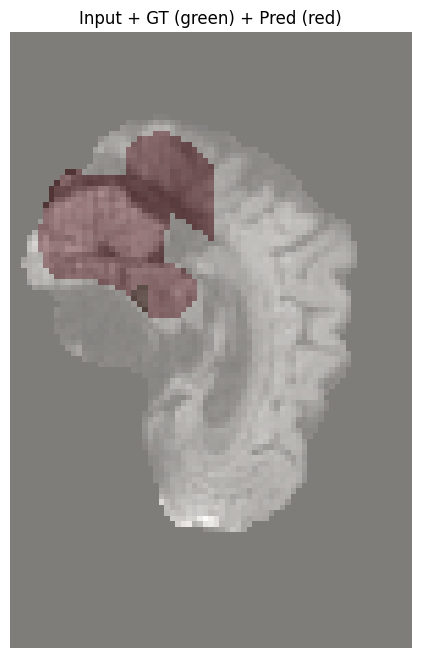

Sample 0: Dice score (ensemble): 0.005567599553614855
Sample 0: Dice score (ensemble): 0.005567599553614855


In [85]:
# %%
print(f"#Load ensemble models")


def load_ensemble(model_paths_dict, device):
    models = []
    print(f"archname {model_paths_dict.items()}")
    for arch_name, paths in model_paths_dict.items():
        for path in paths:
            if arch_name == "unet":
                model = UNet3D.get_unet()
            elif arch_name == "vnet":
                model = VNet.get_vnet()
            elif arch_name == "nnunet":
                model = NNUnet3D.get_nnunet()
            else:
                raise ValueError(f"Unknown architecture: {arch_name}")
            model.load_state_dict(torch.load(arch_name+f"_base_model_{i}.pth", map_location=device))
            model.eval()
            models.append(model.to(device)) # Move model to device
    return models

ensemble_models = load_ensemble(model_paths_dict, DEVICE)

# %%
print(f"#Ensemble prediction on a batch",ensemble_models.count)

# ...existing code...

print(f"#Ensemble prediction on a batch")

def ensemble_predict(models, x, target_shape): # target_shape is passed here
    # target_shape should be the spatial shape (D, H, W) to align to
    with torch.no_grad():
        aligned_preds = []
        for model in models:
            out = model(x)
            # Ensure out is 5D [B, C, D, H, W] for pad_or_crop_to_shape
            while out.ndim < 5:
                out = out.unsqueeze(0) # Add batch or channel dim if missing

            # Align the model output to the target spatial shape
            out_aligned = pad_or_crop_to_shape(out, target_shape) # Error here?
            aligned_preds.append(out_aligned)

    # Now stack the aligned predictions
    stacked = torch.stack(aligned_preds, dim=0)
    avg = torch.mean(stacked, dim=0)
    final = (avg > 0.5).float()

    return final, avg

# Modify the call to ensemble_predict in your prediction section
# You need to pass the target shape. The shape of y after padding is a good target.
# Get a batch from the DataLoader for prediction
x, y = next(iter(train_loader))
print("Input min/max:", x.min(), x.max())
print("Mask unique values:", torch.unique(y))

# Ensure correct dims and type for prediction
if x.ndim == 4:
    x = x.unsqueeze(0) # Add batch dim if missing

# ... in the prediction section ...
x = x.to(DEVICE, dtype=torch.float)

# Determine the target shape for alignment - use the spatial shape of y
# Ensure y is on the correct device if you're accessing its shape later
y = y.to(DEVICE) # Ensure y is on the device if its shape is needed on the device

print("Shape of y before getting target_spatial_shape:", y.shape) # Add this
target_spatial_shape = y.shape[2:] # Get (D, H, W) from the target mask
print("target_spatial_shape:", target_spatial_shape) # Add this


# Pass the target spatial shape to ensemble_predict
# ... in the prediction section ...
target_spatial_shape = y.shape[2:] # This is the target_shape being passed
final_mask, averaged_probs = ensemble_predict(ensemble_models, x, target_spatial_shape)
# ...
# ...existing code...

# ...existing code...

# %%
print(f"#Evaluate and visualize")

# Ensure y has a batch dimension and channel dimension if needed for consistent indexing
if y.ndim == 4:
    y = y.unsqueeze(1) # Add channel dim if missing

for i in range(min(3, x.shape[0])):  # Show up to 3 samples
    # Find a slice with nonzero mask, else use middle
    mask_3d = y[i, 0] if y.ndim == 5 else y[i]
    pred_3d = final_mask[i, 0] if final_mask.ndim == 5 else final_mask[i]
    min_depth = min(mask_3d.shape[0], pred_3d.shape[0], x.shape[2])

    nonzero_slices = torch.where(mask_3d[:min_depth].sum(dim=(-1, -2)) > 0)[0]
    if len(nonzero_slices) > 0:
        slice_idx = int(nonzero_slices[len(nonzero_slices)//2])
    else:
        slice_idx = min_depth // 2  # fallback to middle

    # Always index within min_depth
    print(f"Sample {i}: slice {slice_idx}, input min/max:", x[i, 0, slice_idx].min().item(), x[i, 0, slice_idx].max().item())
    print(f"Sample {i}: mask unique:", torch.unique(mask_3d[slice_idx]))
    print(f"Sample {i}: pred unique:", torch.unique(pred_3d[slice_idx]))

    x_slice = x[i, :, slice_idx, :, :].cpu().squeeze()
    y_slice = mask_3d[slice_idx].cpu().squeeze()
    mask_slice = pred_3d[slice_idx].cpu().squeeze()

    x_slice = x[i, :, slice_idx, :, :].cpu().squeeze()  # [C, H, W] or [H, W]
    y_slice = mask_3d[slice_idx].cpu().squeeze()
    mask_slice = final_mask[i, 0, slice_idx, :, :].cpu().squeeze()

    # Plot using colored visualization
    plot_sample_colored(x_slice, y_slice, mask_slice, channel=0)  # DWI channel

    # Calculate and print additional metrics (implement AVD and F1 first)
    # avd = absolute_volume_difference(mask_slice.numpy(), y_slice.numpy()) # Convert to numpy if needed
    # f1 = lesion_wise_f1_score(mask_slice.numpy(), y_slice.numpy()) # Convert to numpy if needed
    # print(f"Sample {i}: AVD = {avd:.2f}%, Lesion-wise F1 = {f1:.3f}")

    # Print Dice score

        # Ensure mask and prediction have the same shape before dice_score
    pred = final_mask[i]
    target = y[i]
    # Pad/crop pred to match target shape
    for _ in range(target.ndim - pred.ndim):
        pred = pred.unsqueeze(0)
    for _ in range(pred.ndim - target.ndim):
        target = target.unsqueeze(0)
    # Now pad/crop spatial dims
    min_shape = [min(a, b) for a, b in zip(pred.shape, target.shape)]
    pred = pred[..., :min_shape[-3], :min_shape[-2], :min_shape[-1]]
    target = target[..., :min_shape[-3], :min_shape[-2], :min_shape[-1]]

    print(f"Sample {i}: Dice score (ensemble): {dice_score(pred, target)}")

    print(f"Sample {i}: Dice score (ensemble): {dice_score(final_mask[i], y[i])}")
